# Домашнее задание 1

В данной домашке мы немного поупражняемся с обработкой временных данных и базовыми моделями. В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с ликвидностью одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день. Данные достаточно сложные и хорошую модель на них построить непросто, но в учебных целях подойдут.

#### Описание бизнес-процесса, связанного с рядом.

Прогнозная величина позволяет установить сальдо поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключевой-0.9%. В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключевая+1%. 




Выполнил: Тихонов Сергей, БЭК-181

In [1]:
# !pip install sktime[all_extras] --ignore-installed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

plt.rcParams["figure.figsize"] = (23,9)

##### 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты во временных данных. Какова частотность (frequency) данных? Не спешите отвечать на этот вопрос и посмотрите на данные внимательно. Выберите подходящий под данные оффсет и сделайте ресэмпл ряда к этому оффсету.

In [3]:
# Читаем данные

data = pd.read_csv("data.csv")
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Target
Date,
2017-01-09 09:00:00.000,0.000000
2017-01-09 11:00:00.000,-0.421841
2017-01-09 13:00:00.000,0.105555
2017-01-09 15:00:00.000,0.042276
2017-01-09 17:00:00.000,0.071416


In [4]:
# Преобразуем даты во временных данных

data.index = pd.to_datetime(data.index)

**Какова частотность данных:** До 2018-08-31 имеются данные по сальду поступлений в течении дня - в 09:00, 11:00, 13:00, 15:00, 17:00, 19:00, 21:00 и 23:00 - что говорит о частоте в течение дня (каждые два часа). Но начиная с 2018-09-03 данные хранятся по дням, а значит частотность становится дневной. 

Поскольку в условиях задачи требуется построить модель, способную прогнозировать **суммарное значение этого ряда за день**, то и ресэмп будет дневной.

In [5]:
data = data.resample('B').sum()
data.head()

,Target
Date,
2017-01-09,-0.579194
2017-01-10,-1.082260
2017-01-11,-1.515704
2017-01-12,-1.618853
2017-01-13,-1.450091


##### 2) Визуальный анализ (0.5 балла)

Изобразите временной ряд, его автокорреляции и частные автокорреляции до порядка, который сочтёте нужным. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? (Хинт: на коррелограммах разностей ряда некоторые детали могут быть более чёткими)

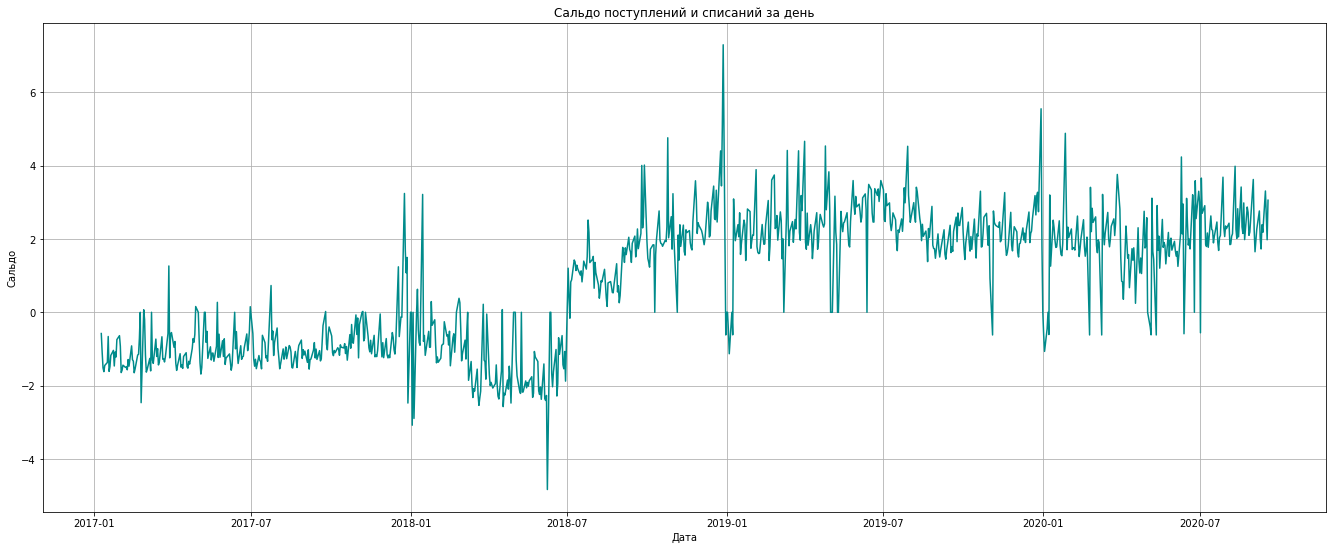

In [6]:
# График сальдо в уровнях

plt.plot(data, color='darkcyan')
plt.title('Сальдо поступлений и списаний за день')
plt.xlabel('Дата')
plt.ylabel('Сальдо')
plt.grid(visible=1);

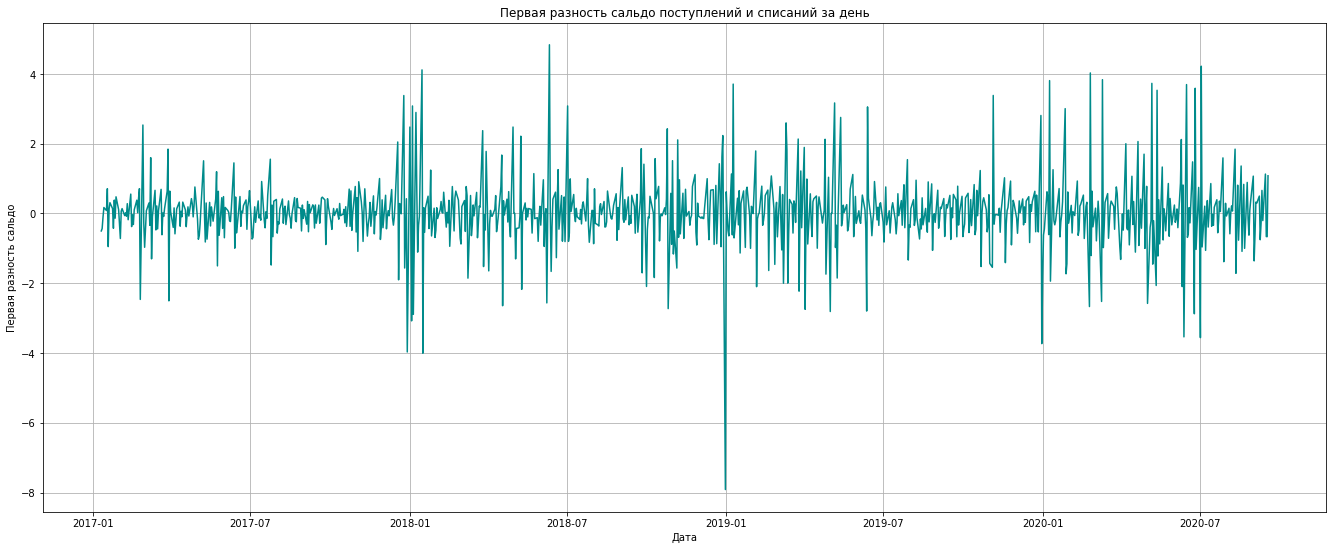

In [7]:
# График сальдо в первых разностях 

plt.plot(data.diff().dropna(), color='darkcyan')
plt.title('Первая разность сальдо поступлений и списаний за день')
plt.xlabel('Дата')
plt.ylabel('Первая разность сальдо')
plt.grid(visible=1);

**Наблюдения по графику ряда** (без коррелограмм):

Структура ряда: 

* Явно заметно структурное изменение в середине ряда (около 2018-09).

Наличие тренда: 

* Явного тренда на графике не наблюдается - сальдо (по определению) является остатком между доходом и расходом, поэтому тренда не ожидается.

Сезонность:

* Сложно определить по графику, для определения сезонности воспользуемся кореллограммами ниже.

Цикличность:

* Теоретически, сумма поступлений/списаний за день (ликвидность банка) может зависет от деловой активности в экономике, т.е. от стадии экономического цикла. Но на приведеном интервали какие либо циклы, кроме сезонных, **отсутствуют**.

Стационарность:

* Более правильно будет проверить стационарность с помощью коррелограмм (выполнено ниже), однако легко заметить, что условия о постоянном математическом ожидании и дисперсии ряда нарушаются из-за обозначенного выше структурного изменение: после него математическое ожидание увеличилось, а разброс ряда вырос.

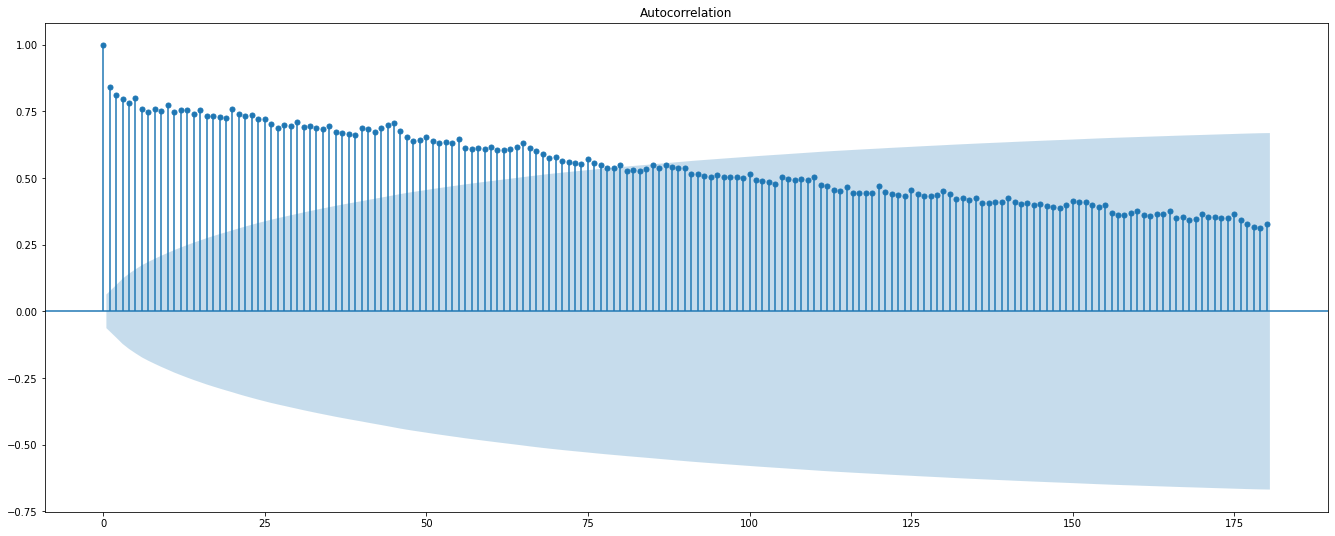

In [8]:
# ACF в уровнях

plot_acf(data, lags=180);

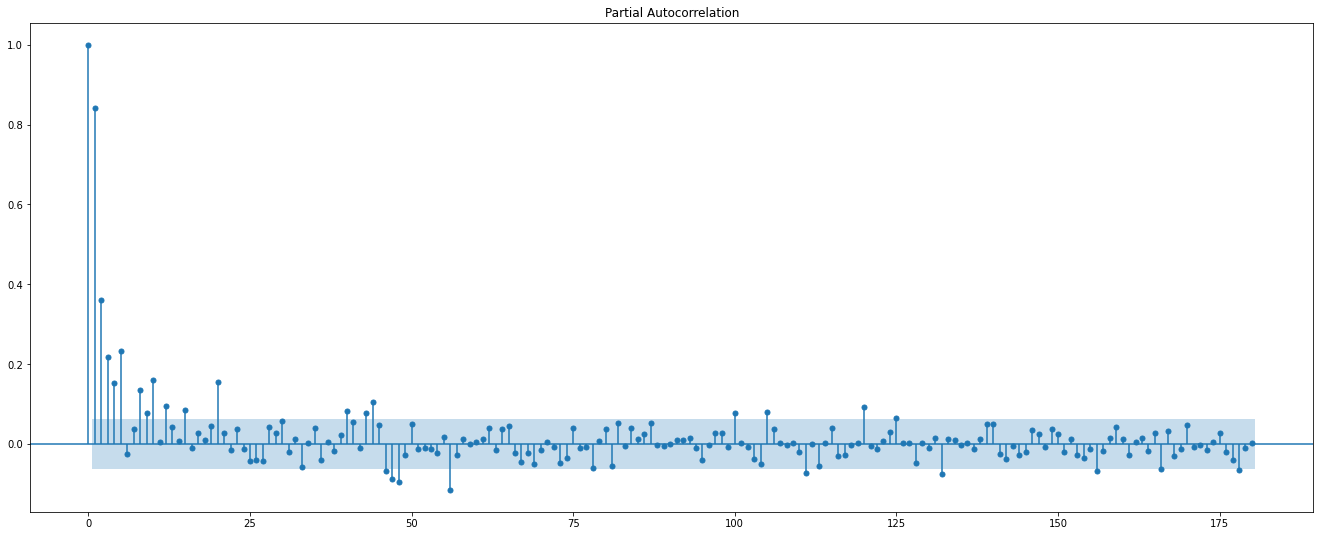

In [9]:
# PACF в уровнях

plot_pacf(data, lags=180);

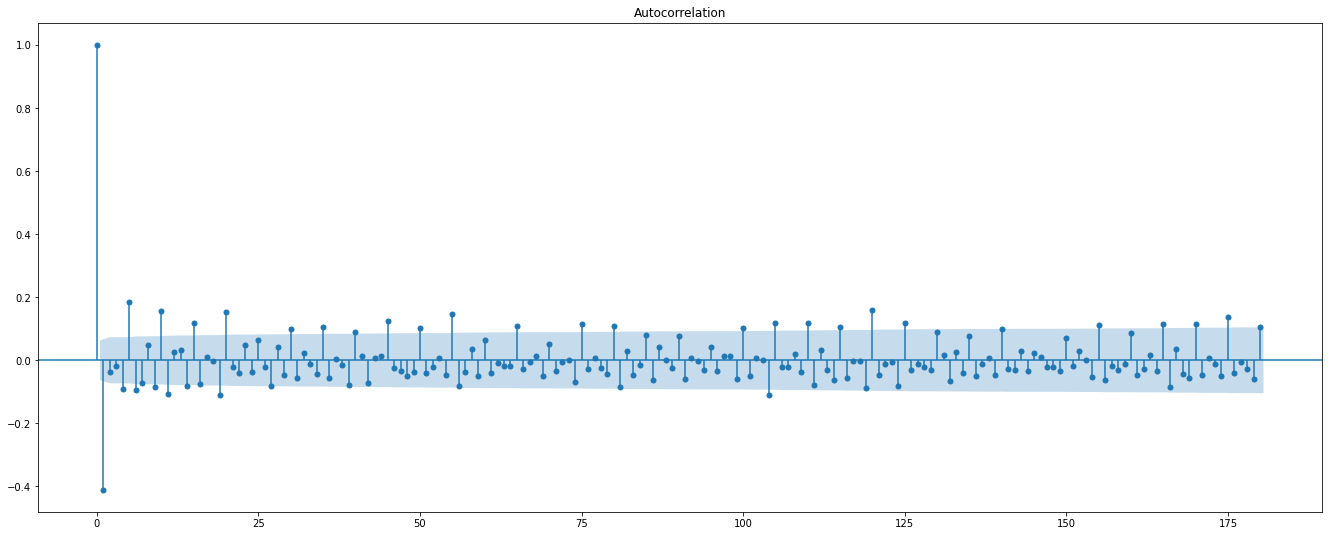

In [10]:
# ACF в первых разностях

plot_acf(data.diff().dropna(), lags=180);

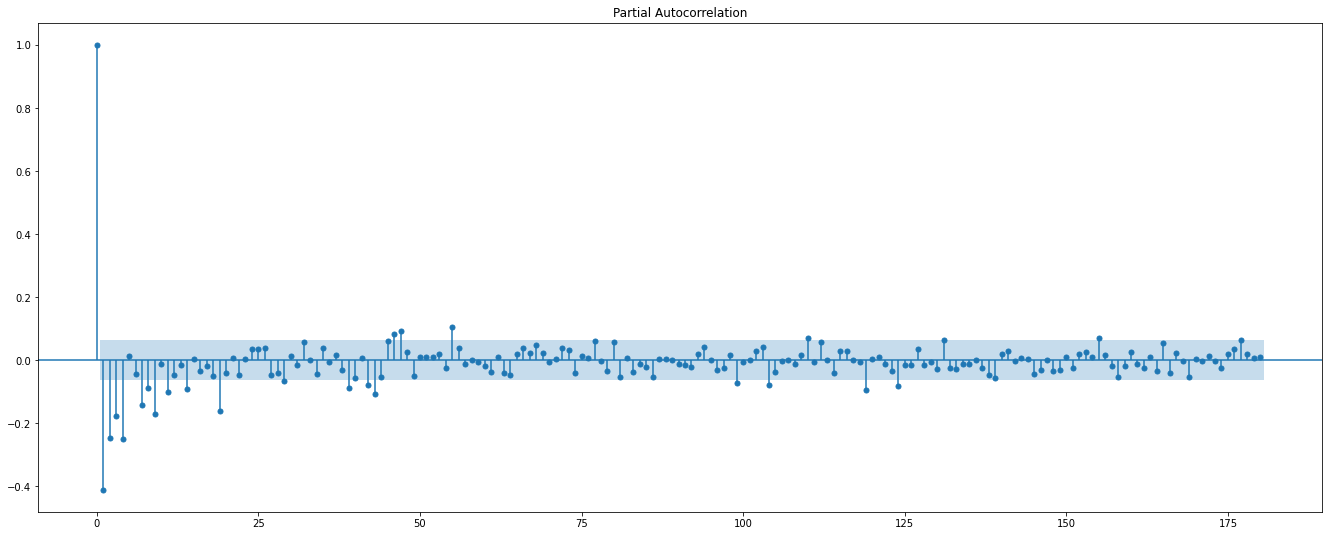

In [11]:
# PACF в первых разностях

plot_pacf(data.diff().dropna(), lags=180);

**Выводы по ACF/PACF**:

Сезонность

* На графике ACF для разностей виден сильный отклик каждый 7 лаг, что сигнализирует о наличии *недельной сезонности*.

* Более того, на графике ACF для разностей значим каждый месячный лаг (28 лаг, с учетом выходных), что говорит о наличии *месячной сезонности*.

Стационарность

* Автокорреляционная функция убывает очень медленно, причём лаги значимые;

* Частная автокорреляционная функция имеет сильный значимый первый лаг, а многие следующие незначимы;

=> Это признаки нестационарного ряда. 

##### 3) Генерация признаков (3 балла)

Внимание! При наличии хотя бы одной утечки в данном блоке стоимость всех пунктов делится на 2, кроме бонусного. Итого максимальный балл при наличии утечек равен 1.5 (или 2.5 при сделанном бонусе).


Создайте следующие признаки. Не забудьте лагировать необходимые фичи. Календарные фичи утечками не являются и могут даже заглядывать в будущее.

1) Календарные фичи (по 0.15 балла за пункт кроме последнего):
<ul>
<li>Индикатор того, что текущий день праздник</li>
<li>Индикатор того, что предыдущий день праздник</li>
<li>Индикатор того, что следующий день праздник </li>
<li>Индикатор того, что предыдущий день выходной</li>
<li>Индикатор того, что следующий день выходной </li>
<li>В середине ряда явно есть структурное изменение. Попробуйте придумать фичу, которая бы помогла это учесть.</li>
<li>Бонус! (1 балл) Одна из важных календарных фичей наряду с праздниками -- налоговые (бухгалтерские) дни. Найти их в удобном для чтения формате не представляется возможным, но это весьма сильная фича.</li>
</ul>

2) Лаги таргета (до 5 разных). (0.1 за все сразу вне зависимости от количества) 

3) Экзогенные фичи (по 0.5 балла каждый пункт):
<ul>
<li>Значение ключевой ставки. Можно поискать на сайте ЦБ</li>
<li>Обменнык курс доллара. Тоже есть на сайте ЦБ либо в любом другом источнике</li>
<li>Ставки Mosprime, все 7 показателей. Есть на сайте Национальной Финансовой Ассоциации</li>
</ul>

4) Придумайте сами 2 различных фичи (по 0.25 за каждую). Выбор каждой фичи кратко обоснуйте.

**Календарные фичи**

Одним из вариантов решения проблемы наличия **структурного изменения** в середине ряда может быть индикатор вида:

$$ \begin{equation*} 
 D = 
 \begin{cases}
   0 & t \leq t_{\text{структурный сдвиг}} \\
   1 & t > t_{\text{структурный сдвиг}}
 \end{cases}
\end{equation*}$$

Момент структурного сдвига (найден эмпирическим путём на графике) выбран:

$$ t_{\text{структурный сдвиг}} = \text{Июль 2018 год}$$

In [42]:
X = pd.DataFrame()
X['target'] = data.Target

# Праздники
rus_holidays = holidays.Russia()
X['is_holiday'] = X.index.to_series().apply(lambda x: x in rus_holidays).astype('int')
X['previous_is_holiday'] = X['is_holiday'].shift(1).fillna(False).astype('int')
X['next_is_holiday'] = X['is_holiday'].shift(-1).fillna(False).astype('int')

# Выходные дни
X['previous_is_weekend'] = (X.index.weekday == 1).astype('int')
X['next_is_weekend'] = (X.index.weekday == 4).astype('int')

# Структурный сдвиг
X['structural_break'] = np.zeros(X.target.shape[0])
X['structural_break'] = (X.index > pd.Timestamp('2018-07-01')).astype('int')

# Налоговые (бухгалтерские) дни (брал отсюда: https://www.b-kontur.ru/calendar/2017)
financial_accounting = pd.read_csv("financial_accounting.csv")
financial_accounting.Date = pd.to_datetime(financial_accounting.Date, dayfirst=True)
X = pd.merge(X, financial_accounting, how='left', on='Date')

**Лаги таргета**

Вдохновился семинаром :)

In [43]:
# Лаги таргета
X['y_L1'] = X['target'].shift(1)
X['y_L2'] = X['target'].shift(2)
X['y_L3'] = X['target'].shift(3)
X['y_L4'] = X['target'].shift(4)
X['y_L5'] = X['target'].shift(5)
X['y_L6'] = X['target'].shift(6)
X['y_L7'] = X['target'].shift(7)
X['y_L8'] = X['target'].shift(8)
X['y_L14'] = X['target'].shift(14)
X['y_L21'] = X['target'].shift(21)
X['y_L28'] = X['target'].shift(28)

**Экзогенные фичи**

Стоит отметить, что в изначальном датасете учтены выходные дни, но с сальдом равным нулю (в выходные дни сделки не осуществляются). Что касается данных по валютному курсу и ключевой ставки, то они в официальной статистике существуют только в будние дни. Поэтому появляется проблема пропусков. Я решил заполнить их предыдущим значением, что логично, поскольку валютный курс в пятницу составил, например, 70 рублей за доллар, то на выходных (когда торги не осуществляются) он сохранится. Аналогично для ставок.

В этом разделе также возникает проблемы подглядывания в будущее. В чатике Матвей решил, что в момент времени t для предсказания сальдо мы не можем использовать ставки/курс для момента времени t. Поэтому, необходимо их сдвинуть.

In [44]:
# Импорт и преобразования ставки процента
keyrate = pd.read_csv("keyrate.csv", decimal=',', delimiter=';')
keyrate.Date = pd.to_datetime(keyrate.Date, dayfirst=True)

# Соединяем в один датафрейм и заполняем пропуски
X = pd.merge(X, keyrate, how='left', on='Date').fillna(method='ffill')
X.Keyrate = X.Keyrate.shift(1)

In [45]:
# Импорт и преобразования ставок mosprime
mosprime = pd.read_csv("mosprime.csv", decimal=',', delimiter=';')
mosprime.Date = pd.to_datetime(mosprime.Date, dayfirst=True)

# В одном из столбцов пропуски оформлены с помощью тире и минуса :(
mosprime[(mosprime.ON == '-') | (mosprime.ON == '–')] = np.nan
mosprime.ON.fillna(method='ffill', inplace=True)
mosprime.ON = mosprime.ON.apply(lambda x: x.replace(',', '.')).astype('float64')

# Соединяем в один датафрейм и заполняем пропуски
X = pd.merge(X, mosprime, how='left', on='Date').fillna(method='ffill')
X[['ON', '1W','2W', '1M', '2M', '3M', '6M']] = X[['ON', '1W','2W', '1M', '2M', '3M', '6M']].shift(1)

In [46]:
# Импорт и преобразование валютного курса
exchange = pd.read_csv("currency.csv", decimal=',', delimiter=';')
exchange.Date = pd.to_datetime(exchange.Date, dayfirst=True)

# Соединяем в один датафрейм и заполняем пропуски
X = pd.merge(X, exchange, how='left', on='Date').fillna(method='ffill')
X.Exchange = X.Exchange.shift(1)

**Мои фичи**

Я создал 3 вида *моих* фичей, т.к. это поможет с прогнозированием:

1. Скользящее среднее. Данная фича обсуждалась на лекции. Её механизм заключается в том, что мы берем n последних периодов и усредняем их. Считается, что динамика многих показателей так или иначе зашумлена. Скользящее среднее сглаживает шумы. Чем больше n, тем шумы сглаживаются сильнее (длинное скользящее среднее), чем короче - тем сглаживание слабее (короткое скользящее среднее). Однако, при очень большом n каждое следующее наблюдение вносит маленький вклад и индикатор может запаздывать. Чтобы **не было утечек**, мы должны посчитать МА за n периодов, а затем сдвинуть их, так как иначе информация о таргете попадет в выборку для предсказания.

2. Прирост таргета с лагом. Данная фича также обсуждалась на лекции. По сути, представляет собой аналог производной, поскольку время дискретно ($\Delta t = 1$). Чтобы **не было утечек**, мы сдвигаем лаг на 1 единицу, так как иначе информация о таргете попадет в выборку для предсказания. Также сделана сезонная модификация: берётся изменение относительно пика 7 дней назад. Это актуально для нашей задачи, поскольку на графике ACF имеются сильные сезонные паттерны.

3. Синус/косинус по дням/годам. Поможет выделить сезонные паттерны. Здесь утечки отсутствуют, поскольку таргет не участвует в формировании фичи.

In [47]:
X['MA5'] = X['target'].rolling(5).mean().shift(1)
X['MA14'] = X['target'].rolling(14).mean().shift(1)
X['MA21'] = X['target'].rolling(21).mean().shift(1)

In [48]:
X['diff_L1'] = X['target'].diff().shift(1)
X['diff_seasonal7_L1'] = X['target'].diff(7).shift(1)
X['diff_seasonal14_L1'] = X['target'].diff(14).shift(1)

In [49]:
timestamp_s = X.Date.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

X['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
X['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
X['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
X['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

X.index = X.Date
X.drop('Date', axis=1, inplace=True)

##### 4) Одношаговое прогнозирование (1 балл)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Пункты Регрессия и Бенчмарк не будут засчитаны! 

4.1) Предобработка (0.3 балла)

Разбейте полученные данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные. Если необходимо, закодируйте категориальные фичи любым валидным методом.

**Комментарий к заданию**: категориальные фичи уже были закодированы с помощью, по сути, One-Hot-Encoding.

In [50]:
# Выкидываем пропуски, отделяем вектор предсказываемой переменной

X = X.dropna()
y = X.target
X = X.drop(columns=['target'])

In [51]:
# Разделяем на трейн и тест

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.2)

In [52]:
# Нормируем данные

scaler = MinMaxScaler()
num_cols = X.columns[X.dtypes == 'float64'].tolist()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

#scaler = MinMaxScaler()
#y_train = pd.Series(scaler.fit_transform(y_train.values.reshape(-1,1)).reshape(-1, ))
#y_test = pd.Series(scaler.transform(y_test.values.reshape(-1,1)).reshape(-1, ))

4.2) Регрессия (0.3 балла)

Выберите ваш любимый регрессор и решите задачу одношагового прогнозирования. При необходимости подберите гиперпараметры. Кросс-валидацию мы ещё пройти не успели, поэтому можно отбирать параметры на тесте, держа в голове, что так делать не очень хорошо. Подсчитайте качество одношаговых прогнозов. Метрика -- MAPE. 

In [53]:
model = CatBoostRegressor(n_estimators=300,
                          l2_leaf_reg=2,
                          learning_rate=0.025)

model.fit(X_train_scaled, y_train, verbose=0)
y_pred = pd.Series(model.predict(X_test_scaled), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)

0.3706621136050557

In [54]:
dict(zip(X.columns, model.feature_importances_))

{'is_holiday': 4.975032176723845,
 'previous_is_holiday': 0.11737468121526282,
 'next_is_holiday': 1.5726512857962913,
 'previous_is_weekend': 0.29630544277744636,
 'next_is_weekend': 0.5821362973995047,
 'structural_break': 12.257477332913425,
 'is_tax': 5.937133606315516,
 'y_L1': 13.245093510922024,
 'y_L2': 2.0393273726593404,
 'y_L3': 1.282694984702882,
 'y_L4': 7.239293817145374,
 'y_L5': 3.797624436540995,
 'y_L6': 1.5298783231985649,
 'y_L7': 1.841618201727144,
 'y_L8': 1.1991072438927073,
 'y_L14': 1.251418507445628,
 'y_L21': 1.022322321951544,
 'y_L28': 1.8708870102089223,
 'Keyrate': 0.37202866457461137,
 'ON': 0.5937139352721914,
 '1W': 0.7893856617660722,
 '2W': 0.9199170532704617,
 '1M': 1.0646615272428404,
 '2M': 1.060875611391205,
 '3M': 0.5574094915488532,
 '6M': 1.0442878598604406,
 'Exchange': 1.8499894987188232,
 'MA5': 6.708735188298025,
 'MA14': 3.6240422135629933,
 'MA21': 7.402691674301757,
 'diff_L1': 0.9865035118687205,
 'diff_seasonal7_L1': 2.63762721270223,

4.3) Бенчмарк (0.3 балла)

Постройте прогноз с помощью наивной модели. Наивная модель в качестве прогноза возвращает последнее доступное на текущий момент значение из трейна (по сути, фичу первого лага таргета). Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже. С налоговыми датами почти наверное получится лучше.




In [55]:
y_pred_naive = X_test.y_L1
mean_absolute_percentage_error(y_test, y_pred_naive)

0.4807899444470109

4.4) Визуализация (0.1 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели. Подпишите все оси.

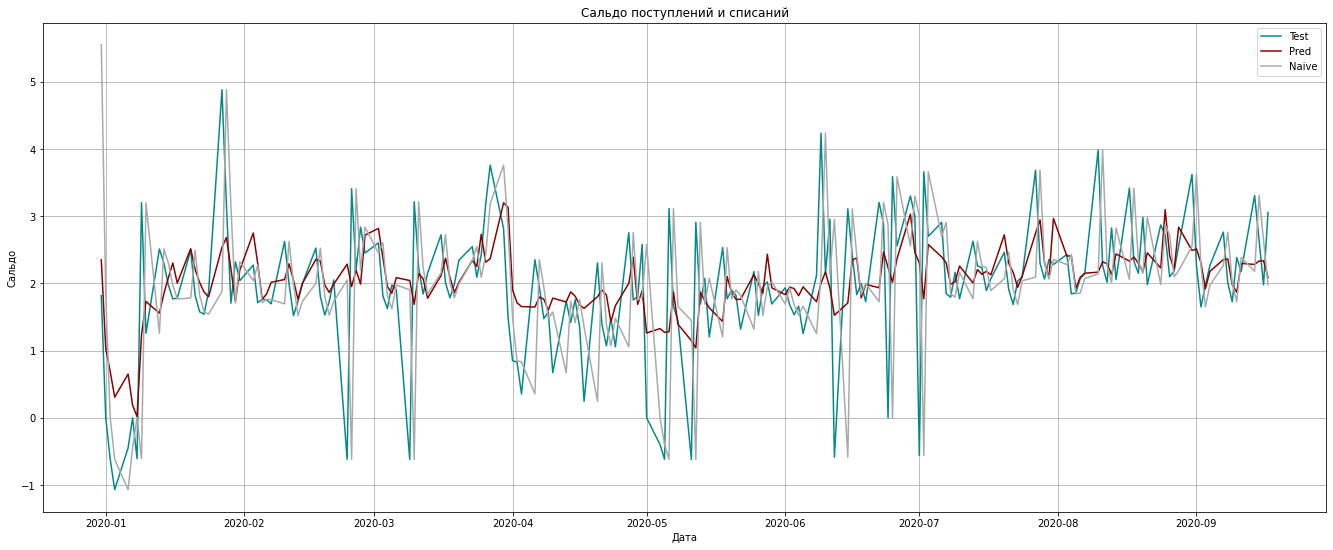

In [56]:
plt.plot(X_test.index, y_test, label='Test', color='darkcyan')
plt.plot(X_test.index, y_pred, label='Pred', color='darkred')
plt.plot(X_test.index, y_pred_naive, label='Naive', color='darkgrey')
plt.title('Сальдо поступлений и списаний')
plt.xlabel('Дата')
plt.ylabel('Сальдо')
plt.grid(visible=1)
plt.legend();

##### Бонус! 

+ +1 балл за MAPE на тесте ниже 0.25. Не засчитывается при наличии утечек в данных.
+ +2 балла за MAPE на тесте ниже 0.20. Не засчитывается при наличии утечек в данных.

Если необходимо, можете добавить новые фичи, но в зачёт блока генерации фичей они не пойдут.

Выполнено выше :)

##### 5) Повтор препроцессинга (0 баллов)

Повторите разбиение на трейн и тест. Размер теста: 15 наблюдений. Оставьте в модели только календарные фичи и лаги таргета. Повторите нормирование и энкодинг, если делали их ранее и если это необходимо. 

In [57]:
X.drop(['Keyrate', 'ON', '1W', '2W', '1M', '2M', '3M', '6M',
       'Exchange', 'MA5', 'MA14', 'MA21', 'diff_L1',
       'diff_seasonal7_L1', 'diff_seasonal14_L1', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin',
       ], axis=1, inplace=True)

# Я также решил выбросить некоторые более поздние лаги, поскольку без них качество выше! 
X.drop(['y_L14','y_L21', 'y_L28'], axis=1, inplace=True)

X.head()

,is_holiday,previous_is_holiday,next_is_holiday,previous_is_weekend,next_is_weekend,structural_break,is_tax,y_L1,y_L2,y_L3,y_L4,y_L5,y_L6,y_L7,y_L8
Date,,,,,,,,,,,,,,,
2017-02-16,0,0,0,0,0,0,0,-1.332381,-1.293751,-0.916031,-1.469439,-1.288388,-1.568191,-1.487835,-1.504238
2017-02-17,0,0,0,0,1,0,0,-1.649205,-1.332381,-1.293751,-0.916031,-1.469439,-1.288388,-1.568191,-1.487835
2017-02-20,0,0,0,0,0,0,0,-1.545918,-1.649205,-1.332381,-1.293751,-0.916031,-1.469439,-1.288388,-1.568191
2017-02-21,0,0,0,1,0,0,0,-1.166033,-1.545918,-1.649205,-1.332381,-1.293751,-0.916031,-1.469439,-1.288388
2017-02-22,0,0,1,0,0,0,0,-1.145739,-1.166033,-1.545918,-1.649205,-1.332381,-1.293751,-0.916031,-1.469439


In [58]:
# Разделяем на трейн и тест

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=15)

##### 6) Рекурсивная стратегия (2.5 балла)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Рекурсивную стратегию необходимо написать вручную!

 Реализуйте рекурсивное прогнозирование на 15 шагов с помощью вашей любимой регрессионной модели.

**Объяснение почему не заглядываю в будущее**: 

Из лагов матрицы X_test я использую только лаги нулевого элемента. Эти лаги содержать 8 последних значений из трейна => они считаются нам известными (содержатся в сигма-алгебре). Далее, на каждом шаге предсказания я сдвигаю матрицу X_test на 1 единицу вправо и на 1 единицу вниз, а образовавшийся пропуск заполняю предсказанным значением.

In [59]:
class RecursiveForecast(object):
    
    def __init__(self, Forecast_horizon = 15):
            
        self.Forecast_horizon = Forecast_horizon
        self.exog_features = ['is_holiday', 'previous_is_holiday', 'next_is_holiday', 'previous_is_weekend', 
                     'next_is_weekend', 'structural_break', 'is_tax']
        self.lags = ['y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8']

            
        
    def fit(self, X_train, y_train):
            
        self.model = RandomForestRegressor(n_estimators=150)
        self.model.fit(X_train.values, y_train.values)  
        
        return self
    
    
    def predict(self, X_test):
            
        y_pred = np.zeros(self.Forecast_horizon)
        X_lags_known = X_test[self.lags].iloc[0]

        for i in range(self.Forecast_horizon):

                X_test_rec = pd.concat([X_test[self.exog_features].iloc[i], X_lags_known])
                y_pred[i] = self.model.predict(X_test_rec.values.reshape(1,-1)) 
                X_lags_known = X_lags_known.shift(1).fillna(y_pred[i]) 
        
        return y_pred

In [82]:
model = RecursiveForecast()
model.fit(X_train, y_train)
y_pred_rec = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred_rec)

0.17963549309495364

##### 7) Прямая стратегия (2 балла)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Прямую стратегию необходимо написать вручную!

 Реализуйте прямое прогнозирование на 15 шагов с помощью вашей любимой регрессионной модели.

**Объяснение почему не заглядываю в будущее**: 

Из лагов матрицы X_test я использую только лаги нулевого элемента. Эти лаги содержать 8 последних значений из трейна => они считаются нам известными (содержатся в сигма-алгебре).

In [61]:
class DirectForecast(object):
    
    def __init__(self, Forecast_horizon = 15):
            
        self.Forecast_horizon = Forecast_horizon
        self.exog_features = ['is_holiday', 'previous_is_holiday', 'next_is_holiday', 'previous_is_weekend', 
                     'next_is_weekend', 'structural_break', 'is_tax']
        self.lags = ['y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8']
        self.estimators = []
            
        
    def fit(self, X_train, y_train):
            
        for i in range(self.Forecast_horizon):
    
            X_train_dir = np.concatenate([X_train[self.exog_features].iloc[i : X_train.shape[0]-14+i].values, 
                             X_train[self.lags].iloc[: X_train.shape[0]-14].values], axis=1)
        
            model = RandomForestRegressor(n_estimators=150)
            model.fit(X_train_dir, y_train[i : X_train.shape[0]-14+i])
            self.estimators.append(model)  
            
        return self
    
    
    def predict(self, X_test):
      
        y_pred = np.zeros(self.Forecast_horizon)
        X_lags_known = X_test[self.lags].iloc[0]
        X_lag = np.array(self.Forecast_horizon * X_lags_known.tolist()).reshape(-1, len(self.lags))
        X_test_dir = np.concatenate([X_test[self.exog_features], X_lag], axis=1)
            
        for i in range(self.Forecast_horizon):
    
            y_pred[i] = self.estimators[i].predict(X_test_dir[i : i+1]) 
    
        return y_pred       

In [66]:
model = DirectForecast()
model.fit(X_train, y_train)
y_pred_dir = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred_dir)

0.1716585617019397

##### 8) Результаты (0.5 балла)

Визуализируйте прогнозы двух стратегий и тестовые данные на одном графике. Подсчитайте MAPE прогнозов двух моделей. Какая оказалась лучше?

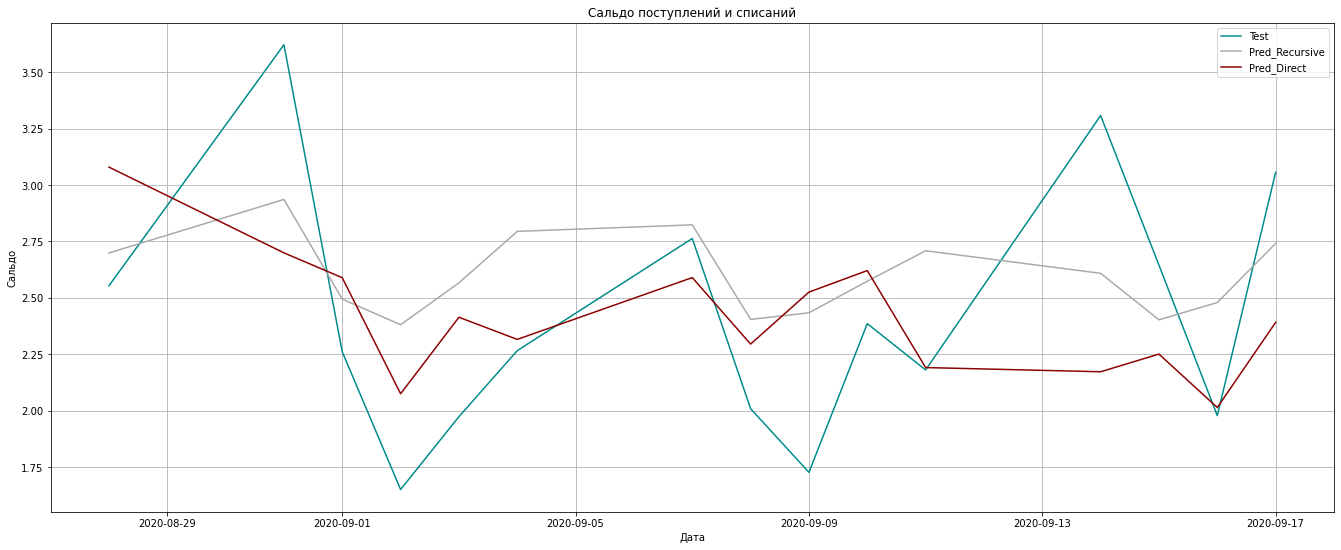

In [83]:
plt.plot(X_test.index, y_test, label='Test', color='darkcyan')
plt.plot(X_test.index, y_pred_rec, label='Pred_Recursive', color='darkgrey')
plt.plot(X_test.index, y_pred_dir, label='Pred_Direct', color='darkred')
plt.title('Сальдо поступлений и списаний')
plt.xlabel('Дата')
plt.ylabel('Сальдо')
plt.grid(visible=1)
plt.legend();

**Выводы**:

Я использовал алгоритм случайного леса.

Для него, как и для других алгоритмов, был достигнут ожидаемый результат: ошибка у прямой стратегии оказалась ниже, чем ошибка у реккурентной. Этот теоретический факт обсуждался на семинаре: ошибки предыдущих горизонтов не влияют на проноз по текущему (не происходит накопления ошибки). Однако, стоит помнить, что растёт общий разброс модели, так как оцениваем в h раз больше параметров.

##### 9) Скиньте последний мем, который заставил посмеяться (Респект ассистента и семинариста)

<center><img src="https://sun9-41.userapi.com/impg/NeF6br0fjVHxy7BHZA4D7vo87jXUQTem6LrqUQ/dfDHn8KwuHo.jpg?size=604x586&quality=96&sign=fedca9e372e7a22b532dda401c8040d3&type=album" ></center>

In [34]:
# Что понравилось в домашке:

# 1. Хорошо получилось отразить, что процесс сбора/обработки данных важен и сложен, что часто дата собрана в неудобных форматах
# 2. Написать самому страгеии и интересно, и хорошо помогает разобраться в них
# 3. Домашка сама несложная, не нужно париться с подбором параметров (этому нас учат в других курсах)

# Что не понравилось:

# Довольно запарная домашка в смысле времени. То есть все задания несложные и понятные, но пока их делаешь (ищешь и 
# обрабатываешь данные, соединяешь таблицы) - уходит много времени.

# В целом конечно всё круто!!!